In [1]:
%reset
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

#IPython is what you are using now to run the notebook
import IPython
print ("IPython version:      %6.6s (need at least 6.1.0)" % IPython.__version__)

# Numpy is a library for working with Arrays
import numpy as np
print ("Numpy version:        %6.6s (need at least 1.13.1)" % np.__version__)

# SciPy implements many different numerical algorithms
import scipy as sp
print ("SciPy version:        %6.6s (need at least 0.19.1)" % sp.__version__)

# Pandas makes working with data tables easier
import pandas as pd
print ("Pandas version:       %6.6s (need at least 0.20.3)" % pd.__version__)

# SciKit Learn implements several Machine Learning algorithms
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
print ("Scikit-Learn version: %6.6s (need at least 0.19.0)" % sklearn.__version__)

from itertools import combinations as cmb

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


IPython version:       7.8.0 (need at least 6.1.0)
Numpy version:        1.17.2 (need at least 1.13.1)
SciPy version:         1.3.1 (need at least 0.19.1)
Pandas version:       0.25.1 (need at least 0.20.3)
Scikit-Learn version: 0.22.1 (need at least 0.19.0)


In [2]:
# Set font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# import data
neutral_full = np.loadtxt('./Neutral.csv',delimiter=';',usecols=range(8))
closed_full = np.loadtxt('./Closed.csv',delimiter=';',usecols=range(8))
open_full = np.loadtxt('./Open.csv', delimiter=';',usecols=range(8))
flexion_full = np.loadtxt('./Flexion.csv',delimiter=';',usecols=range(8))
extension_full = np.loadtxt('./Extension.csv',delimiter=';',usecols=range(8))
ulnar_full = np.loadtxt('./Ulnar Deviation.csv',delimiter=';',usecols=range(8))
radial_full = np.loadtxt('./Radial Deviation.csv',delimiter=';',usecols=range(8))
pronation_full = np.loadtxt('./Pronation.csv',delimiter=';',usecols=range(8))
supination_full = np.loadtxt('./Supination.csv',delimiter=';',usecols=range(8))

# Combine data into navigable structure
full_dset = [neutral_full, closed_full, open_full, flexion_full, extension_full, ulnar_full, radial_full, pronation_full, supination_full]
n_classes = len(full_dset)


In [4]:
# Calculates RMS's of 250ms chunks (for all channels, single class)
def rms(data):
    output = np.zeros((8,120))
    for i in range(8):
        for j in range(120):
            low = j * 50
            high = low + 50
            output[i,j] = np.sqrt(np.mean(data[low:high,i]**2))
    return output

In [5]:
# Perform RMS calculation
rms_t = np.empty((8,0))
rms_v = np.empty((8,0))
for i,dset in enumerate(full_dset):
    rmss = rms(dset)
    rms_t = np.append(rms_t,rmss[:,:int(len(rmss[0])*0.25)],axis=1)
    rms_v = np.append(rms_v,rmss[:,int(len(rmss[0])*0.25):],axis=1)

In [6]:
def lda_format(rms_set):
    # Reformat data for LDA classifier
    classes = np.empty((1,0))
    n_samples = int(len(rms_set[0])/n_classes)
    for i in range(n_classes):
        classes = np.append(classes,np.full((1,n_samples),int(i)),axis=1)
    zipped = np.concatenate((rms_set,classes),axis=0)    
    zipped = np.swapaxes(zipped,0,1)
    np.random.shuffle(zipped)
    data = zipped[:,:-1]
    classes = np.ravel(zipped[:,-1:])
    return(data,classes)

In [7]:
# Format Data
data_t,classes_t = lda_format(rms_t)
data_v,classes_v = lda_format(rms_v)

# Perform LDA fit
lda = LDA()
lda.fit(data_t, classes_t)

# Perform QDA fit
qda = QDA()
qda.fit(data_t, classes_t)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [16]:
# Function for evaluating LDA success
def lda_eval(lda, v_data, v_classes):
    pred = lda.predict(v_data)
    num_correct = 0
    misses = []
    for i,p in enumerate(pred):
        if v_classes[i] == p:
            num_correct += 1
        else:
            misses.append((v_classes[i],p))
    pos_rate = num_correct/len(v_classes)
    return (pred,pos_rate,misses)
    
pred,rate,misses = lda_eval(lda, data_v, classes_v)
print('True Positive Rate: '+str(rate))

True Positive Rate: 0.9543209876543209


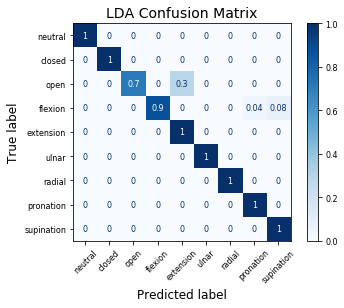

In [9]:
a = plt.axes()
plt.title("LDA Confusion Matrix",fontdict={'fontsize': 14})
sklearn.metrics.plot_confusion_matrix(lda,data_v,classes_v,
                                      xticks_rotation=45,
                                      values_format='0.1g',
                                      cmap=plt.cm.Blues,
                                      normalize='true',
                                      ax=a,
                                      display_labels=["neutral", 
                                                      "closed", 
                                                      "open", 
                                                      "flexion", 
                                                      "extension", 
                                                      "ulnar", 
                                                      "radial", 
                                                      "pronation", 
                                                      "supination"],)

plt.savefig('9-Pose LDA Confusion Matrix.pdf',bbox_inches='tight')

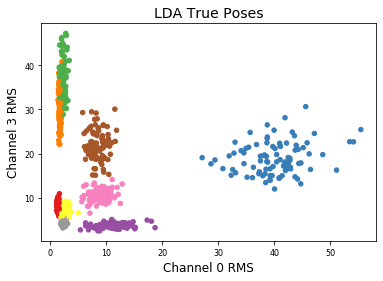

In [10]:
plt.title("LDA True Poses",fontdict={'fontsize': 14})
plt.xlabel("Channel 0 RMS",fontdict={'fontsize': 12})
plt.ylabel("Channel 3 RMS",fontdict={'fontsize': 12})
plt.scatter(data_v[:,0], data_v[:,3], c=classes_v, s=20, cmap='Set1')
plt.savefig("9-Class LDA True Classes Scatter.pdf")

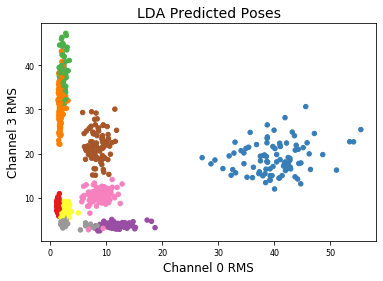

In [12]:
plt.title("LDA Predicted Poses",fontdict={'fontsize': 14})
plt.xlabel("Channel 0 RMS",fontdict={'fontsize': 12})
plt.ylabel("Channel 3 RMS",fontdict={'fontsize': 12})
plt.scatter(data_v[:,0], data_v[:,3], c=pred, s=20, cmap='Set1')
plt.savefig("9-Class LDA Predicted Classes Scatter.pdf")

In [13]:
# Function for evaluating QDA success
def qda_eval(qda, v_data, v_classes):
    pred = qda.predict(v_data)
    num_correct = 0
    misses = []
    for i,p in enumerate(pred):
        if v_classes[i] == p:
            num_correct += 1
        else:
            misses.append((v_classes[i],p))
    pos_rate = num_correct/len(v_classes)
    return (pred,pos_rate,misses)
    
pred,rate,misses = qda_eval(qda, data_v, classes_v)
print(rate)
print(misses)

1.0
[]


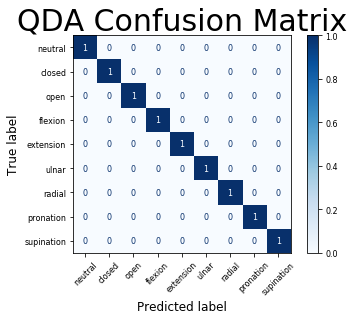

In [14]:
a = plt.axes()
plt.title("QDA Confusion Matrix",fontdict={'fontsize': 30})
sklearn.metrics.plot_confusion_matrix(qda,data_v,classes_v,
                                      xticks_rotation=45,
                                      cmap=plt.cm.Blues,
                                      normalize='true',
                                      ax=a,
                                      display_labels=["neutral", 
                                                      "closed", 
                                                      "open", 
                                                      "flexion", 
                                                      "extension", 
                                                      "ulnar", 
                                                      "radial", 
                                                      "pronation", 
                                                      "supination"],)